In [37]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable
from torch.utils import data

# Data Preprocessing

In [38]:

D = pd.read_csv('/home/gaia/NDO_UTILIZATION/Autoencodertestdata.csv')


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['DL User Througput (kbps)_Last_7_days_Avg',
       'UL User Throughput (kbps)_Last_7_days_Avg',
       'Payload All_Last_7_days_Avg', 'Payload Ul ( MB)_Last_7_days_Avg',
       'Payload DL ( MB )_Last_7_days_Avg', 'DL PRB UTIL_Last_7_days_Avg',
       'Ul PRB UTIL_Last_7_days_Avg',
       'DL User Througput (kbps).1_Last_7_days_Avg',
       'QPSK Samples DL %_Last_7_days_Avg',
       '16 QAM Samples Dl %_Last_7_days_Avg',
       '64 QAM Samples DL %_Last_7_days_Avg',
       '256 QAM Samples DL %_Last_7_days_Avg',
       'UL User Throughput (kbps).1_Last_7_days_Avg',
       'QPSK Samples UL %_Last_7_days_Avg',
       '16 QAM Samples UL %_Last_7_days_Avg',
       '64 QAM Samples Ul %_Last_7_days_Avg',
       'Cell Average Thrp_UL_Last_7_days_Avg',
       'Cell Average Thrp_DL_Last_7_days_Avg',
       'pmRrcConnMax (max)_Last_7_days_Avg',
       'pmRrcConnMax (sum)_Last_7_days_Avg', 'Hour_sin', 'Hour_cos', 'Weekend',
       'is_day', 'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
       'is_nig_weekend', 'CellTDD_LD25099A', 'CellTDD_LD25099B',
       'CellTDD_LD25099C', 'CellTDD_LD25099D', 'CellTDD_LD25099E',
       'CellTDD_LD25099S', 'CellTDD_LD25099T', 'CellTDD_LD25099U',
       'CellTDD_LD25099V', 'CellTDD_LD25099W', 'momentum', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema']:
    scaler.fit(D[col].values.reshape(-1, 1))
    D[col] = scaler.transform(D[col].values.reshape(-1, 1))
    
    
    
    
    
train_length=int(0.90*(len(D)))
test_length=int(0.10*(len(D)))
D_train=D.iloc[240:train_length,20:69]
D_test=D.iloc[train_length:,20:69]


Labels_train=D.iloc[240:train_length,5] 
Labels_train=pd.DataFrame(Labels_train)
Labels_train['binaryout'] = Labels_train['DL PRB UTIL'].apply(lambda x: 1 if x >= 80 else 0)

D_train=torch.tensor(np.asarray(D_train))
D_test=torch.tensor(np.asarray(D_test))

train_loader = data.DataLoader(D_train, batch_size=16, shuffle=True)
test_loader = data.DataLoader(D_test, batch_size=16, shuffle=False)


In [39]:
Labels_train[Labels_train['binaryout']==0]

,DL PRB UTIL,binaryout
240,18.21,0
241,23.69,0
242,69.43,0
243,77.91,0
244,31.55,0
...,...,...
3019,53.68,0
3020,16.30,0
3021,32.67,0
3022,68.32,0


# Creating your AutoEncoder Network

In [40]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(49, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 3),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 49),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Useful Functions For implementing Relational Function in Loss

In [41]:


def L(X, X_, t):
    if t == 'mse':
        l=nn.MSELoss()
        return l(X, X_)
     

def R(X):
    return torch.mm(X, torch.t(X))

def tau(X, t):
    return torch.where(X < t, X.float(), torch.zeros(X.shape).float())

def rae_loss(alpha, t, L_type='mse'):
    def rae(y_true, y_pred):
        return (1 - alpha)*L(y_true, y_pred, L_type) + alpha*L(tau(R(y_true), t), tau(R(y_pred), t), L_type)
    return rae

# Setting up Your Alphas

In [42]:
alphas = np.linspace(0, 1, 15)
t = 1
alpha=alphas[1]
#alpha=0.05
#rae_loss(alpha, t, 'mse')
print(alpha)
print(alphas)

0.07142857142857142
[0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]


# Function For Model Train

In [43]:
def model_training(autoencoder, train_loader, epoch):
    #loss_metric = nn.MSELoss()
    loss_metric =rae_loss(alpha, t, 'mse')
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        DataPoint = data.float()
        DataPoint = Variable(DataPoint)
        DataPoint = DataPoint.view(DataPoint.size(0), -1)
        #if cuda: DataPoint = DataPoint.to(device)
        outputs = autoencoder(DataPoint)
        loss = loss_metric(outputs, DataPoint)
        loss.backward()
        optimizer.step()
        if (i + 1) % LOG_INTERVAL == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], HUBER loss:{:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader.dataset) // BATCH_SIZE, loss.item()
            ))

# Function for Model Evaluation

In [44]:
def evaluation(autoencoder, test_loader):
    total_loss = 0
    #loss_metric = nn.MSELoss()
    loss_metric =rae_loss(alpha, t, 'mse')
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        DataPoint = data.float()
        DataPoint = Variable(DataPoint)
        DataPoint = DataPoint.view(DataPoint.size(0), -1)
        #if cuda: DataPoint = DataPoint.to(device)
        outputs = autoencoder(DataPoint)
        loss = loss_metric(outputs, DataPoint)
        total_loss += loss * len(DataPoint)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))

    global BEST_VAL
    if TRAIN_SCRATCH and avg_loss < BEST_VAL:
        BEST_VAL = avg_loss
        torch.save(autoencoder.state_dict(), './simple_autoencoder.pt')
        print('Save Best Model\n')


# Network Execution

In [45]:
import datetime

if __name__ == '__main__':

    EPOCHS = 100
    BATCH_SIZE = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    LOG_INTERVAL = 100
    TRAIN_SCRATCH = True        # whether to train a model from scratch
    BEST_VAL = float('inf')     # record the best val loss

    #train_loader, test_loader = data_utils.load_mnist(BATCH_SIZE)
    torch.manual_seed(39)

    autoencoder = Autoencoder()
    #if cuda: autoencoder.to(device)

    if TRAIN_SCRATCH:
        # Training autoencoder from scratch
        for epoch in range(EPOCHS):
            starttime = datetime.datetime.now()
            model_training(autoencoder, train_loader, epoch)
            endtime = datetime.datetime.now()
            print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
            # evaluate on test set and save best model
            evaluation(autoencoder, test_loader)
        print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

    else:
        autoencoder.load_state_dict(torch.load('/simple_autoencoder.pt'))
        evaluation(autoencoder, test_loader)

        autoencoder.cpu()
        dataiter = iter(train_loader)
        DataPoint, _ = next(dataiter)
        DataPoint = Variable(DataPoint[:32])
        outputs = autoencoder(DataPoint.view(DataPoint.size(0), -1))



Epoch [1/100] - Iter[100/27], HUBER loss:8.0869
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.2875
Save Best Model

Epoch [2/100] - Iter[100/27], HUBER loss:4.3177
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.5854
Epoch [3/100] - Iter[100/27], HUBER loss:3.6070
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.8554
Epoch [4/100] - Iter[100/27], HUBER loss:3.6328
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.8868
Epoch [5/100] - Iter[100/27], HUBER loss:3.4474
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.2232
Save Best Model

Epoch [6/100] - Iter[100/27], HUBER loss:2.8630
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.5166
Epoch [7/100] - Iter[100/27], HUBER loss:4.0934
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.5060
Epoch [8/100] - Iter[100/27], HUBER loss:3.0101
Train a epoch in 1 seconds

Average MSE Loss on Test set: 1.6167
Epoch [9/100] - Iter[100/27], HUBER loss:4.1633
Train a epoch 

# Visualizing on of the Samples

# For Alpha=0

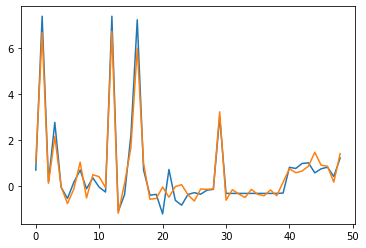

In [30]:
x = D_train[200].float()
enc_output = autoencoder.decoder(autoencoder.encoder(x))


xhat=np.array(list(enc_output))
x=np.array(list(x))

import matplotlib.pyplot as plt
plt.plot(x)
plt.plot(xhat)

# Module for Feature Embedding

In [31]:
x = D_train.float()
dec_output = autoencoder.decoder(autoencoder.encoder(x))
enc_output = autoencoder.encoder(x)
#enc_outputt=list(enc_output)
enc_outputt=(enc_output).detach().numpy()

In [32]:
enc_outputt

array([[ 0.4880912 ,  6.3007784 ,  3.6048012 ],
       [ 0.13819584,  0.38005137,  1.2404145 ],
       [22.479778  , 23.938543  , 18.071741  ],
       ...,
       [ 1.1073712 ,  1.7295833 ,  4.522964  ],
       [15.17144   ,  7.3445363 , 11.245966  ],
       [12.079264  ,  4.558415  ,  7.9865    ]], dtype=float32)

In [33]:
Labels_train.shape,enc_output.shape

((2784, 2), torch.Size([2784, 3]))

# Plotting Extracted Feature in Lower Spaces

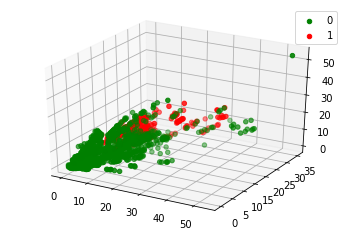

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

scatter_x = enc_outputt[:, 2]
scatter_y = enc_outputt[:, 0]
scatter_z= enc_outputt[:, 1]

group = np.asarray(Labels_train.iloc[:,1])
cdict = {1: 'red', 0: 'green'}


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_z[ix],scatter_x[ix],scatter_y[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

#s = 100

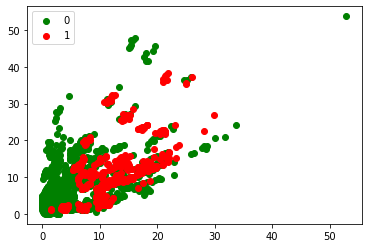

In [35]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

scatter_x = enc_outputt[:, 0]
scatter_y = enc_outputt[:, 1]
#scatter_z= X_embedded[:, 2]
group = np.asarray(Labels_train.iloc[:,1])
cdict = {1: 'red', 0: 'green'}



fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

#s = 100

In [36]:
##autoencoder.state_dict()

# For Alpha=0.07

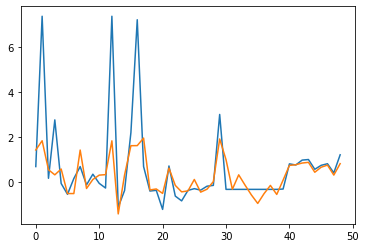

In [46]:
x = D_train[200].float()
enc_output = autoencoder.decoder(autoencoder.encoder(x))


xhat=np.array(list(enc_output))
x=np.array(list(x))

import matplotlib.pyplot as plt
plt.plot(x)
plt.plot(xhat)

In [47]:
x = D_train.float()
dec_output = autoencoder.decoder(autoencoder.encoder(x))
enc_output = autoencoder.encoder(x)
#enc_outputt=list(enc_output)
enc_outputt=(enc_output).detach().numpy()

# In 3D

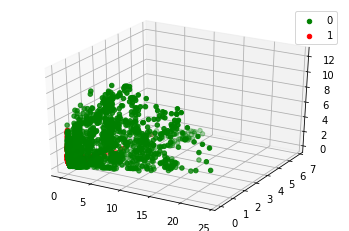

In [48]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

scatter_x = enc_outputt[:, 2]
scatter_y = enc_outputt[:, 0]
scatter_z= enc_outputt[:, 1]

group = np.asarray(Labels_train.iloc[:,1])
cdict = {1: 'red', 0: 'green'}


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_z[ix],scatter_x[ix],scatter_y[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

#s = 100

# In 2D

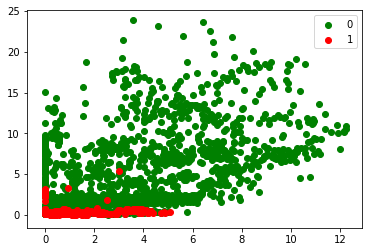

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

scatter_x = enc_outputt[:, 0]
scatter_y = enc_outputt[:, 1]
#scatter_z= X_embedded[:, 2]
group = np.asarray(Labels_train.iloc[:,1])
cdict = {1: 'red', 0: 'green'}



fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

#s = 100

## END AutoENCODER